In [100]:
import pandas as pd

frequency = 'annual'

# Read Statistics Canada formatted data
strikeCountsDf = pd.read_csv(f"data/{frequency}/strikes/strike-count.csv")
strikeAverageDurationsDf = pd.read_csv(f"data/{frequency}/strikes/strike-average-duration.csv")
strikeDaysNotWorkedDf = pd.read_csv(f"data/{frequency}/strikes/strike-days-not-worked.csv")
unionizationDf = pd.read_csv(f"data/{frequency}/unionizationRate.csv")

# Read FRED Data
unemploymentDf = pd.read_csv(f"data/{frequency}/unemployment.csv")
realGdpDf = pd.read_csv(f"data/{frequency}/real-gdp.csv")
inflationDf = pd.read_csv(f"data/{frequency}/inflation.csv")
populationDf = pd.read_csv(f"data/{frequency}/population.csv")

# Read Labour Share Data
# Household Compensation is Statistics Canada data, but it has been modified in Excel to have years as the dates
householdCompensationDf = pd.read_csv(f"data/{frequency}/labour-share/household-compensation.csv")

# Nominal GDP is Fred data
nominalGdpDf = pd.read_csv(f"data/{frequency}/labour-share/nominal-gdp.csv")

In [101]:
# Cleaning data
# Convert all FRED dates to the just a year
def convertToYears(date):
    return int(date[:4])

fredDfs = [unemploymentDf, realGdpDf, inflationDf, populationDf, nominalGdpDf]

for df in fredDfs:
    df['DATE'] = df['DATE'].apply(convertToYears)

# Rename datasets and drop unnecessary rows
strikeCountsDf = strikeCountsDf.rename(columns={'VALUE': 'strikeCounts'})
strikeAverageDurationsDf = strikeAverageDurationsDf.rename(columns={'VALUE': 'strikeAverageDurations'})
strikeDaysNotWorkedDf = strikeDaysNotWorkedDf.rename(columns={'VALUE': 'strikesDaysNotWorked'})
unionizationDf = unionizationDf.rename(columns={'VALUE': 'unionizationRate'})

householdCompensationDf = householdCompensationDf.rename(columns={'VALUE': 'householdCompensation'})
nominalGdpDf = nominalGdpDf.rename(columns={'NGDPXDCCAA': 'nominalGdp'})

realGdpDf = realGdpDf.rename(columns={'NGDPRXDCCAA': 'realGdp'})
unemploymentDf = unemploymentDf.rename(columns={'LRUNTTTTCAA156S': 'unemploymentRate'})
inflationDf = inflationDf.rename(columns={'FPCPITOTLZGCAN': 'inflationRate'})
populationDf = populationDf.rename(columns={'POPTOTCAA647NWDB': 'population'})


In [102]:
# Merge into one dataframe
allDfs = [strikeCountsDf, strikeAverageDurationsDf, strikeDaysNotWorkedDf, unemploymentDf, realGdpDf, inflationDf, populationDf, householdCompensationDf, nominalGdpDf, unionizationDf]

fullDf = strikeCountsDf

for df in allDfs[1:]:
    fullDf = pd.merge(fullDf, df, on='DATE')
    
fullDf = fullDf.rename(columns={'DATE': 'year'})

In [103]:
import numpy as np

# Create all variables
# Create labour share variable
fullDf['labourShare'] = fullDf['householdCompensation'] / fullDf['nominalGdp']

# Make strike counts and days not worked due to strikes relative to 1 000 000 people, to adjust for population size
# Strike duration does not need to be adjusted for this, as it is measuring time
peopleRatioForStrikes = 100000

fullDf['strikeCounts'] = (fullDf['strikeCounts'] / fullDf['population']) * peopleRatioForStrikes
fullDf['strikesDaysNotWorked'] = (fullDf['strikesDaysNotWorked'] / fullDf['population']) * peopleRatioForStrikes

# Create *approximated* growth rate in real GDP
# Uses log differences and the Taylor Series to approximate the growth rate 
fullDf['realGdpGrowthRate'] = np.log(fullDf['realGdp'])
fullDf['realGdpGrowthRate'] =  fullDf['realGdpGrowthRate'].diff()

# Create change in unemployment variable
fullDf['unemploymentRateChange'] = fullDf['unemploymentRate'].diff()

# Create change in inflation rate variable
fullDf['inflationRateChange'] = fullDf['inflationRate'].diff()

# Create dummy variable for inflation targeting period
targetingStartYear = 1991

fullDf['inflationTargetingPeriod'] = fullDf['year'] > targetingStartYear

fullDf['inflationRate_L1'] = fullDf['inflationRate'].shift(1)

# Drop first row since it is now empty (1962 is the first year now)
fullDf = fullDf.drop(index=[0])

# Drop unneeded columns
fullDf = fullDf.drop(columns=['nominalGdp', 'householdCompensation', 'realGdp'])

# Convert % data to larger numbers for easier interpretation
fullDf['labourShare'] = fullDf['labourShare'] * 100
fullDf['realGdpGrowthRate'] = fullDf['realGdpGrowthRate'] * 100

In [104]:
# Obtaining summary statistics of each key data
summaryStatistics = fullDf.describe()
print(summaryStatistics)

              year  strikeCounts  strikeAverageDurations  \
count    62.000000     62.000000               62.000000   
mean   1992.500000      1.872017               37.127419   
std      18.041619      1.338753               15.410728   
min    1962.000000      0.173553               18.300000   
25%    1977.250000      0.699432               24.875000   
50%    1992.500000      1.537670               35.800000   
75%    2007.750000      2.700380               40.700000   
max    2023.000000      5.335854               97.700000   

       strikesDaysNotWorked  unemploymentRate  inflationRate    population  \
count             62.000000         62.000000      62.000000  6.200000e+01   
mean           14390.082132          7.430914       3.825732  2.855326e+07   
std            12254.942043          1.988538       2.972673  5.878433e+06   
min             1749.836469          3.375000       0.165563  1.861400e+07   
25%             5198.435407          6.175000       1.796968  2.37851

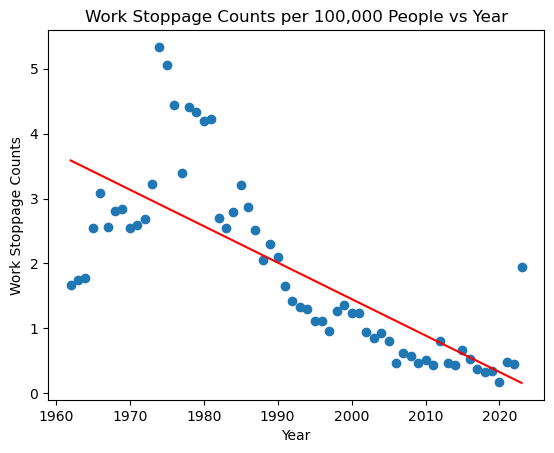

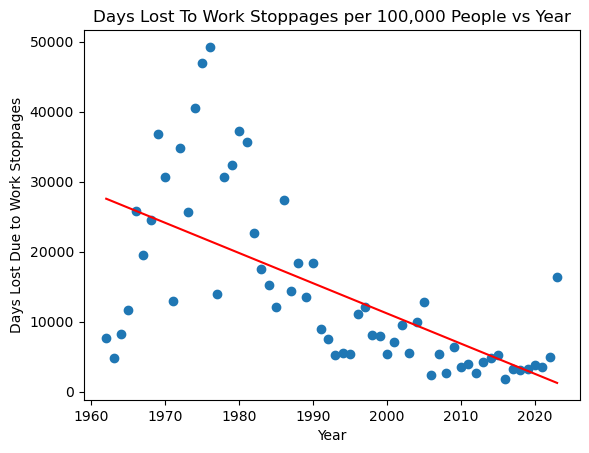

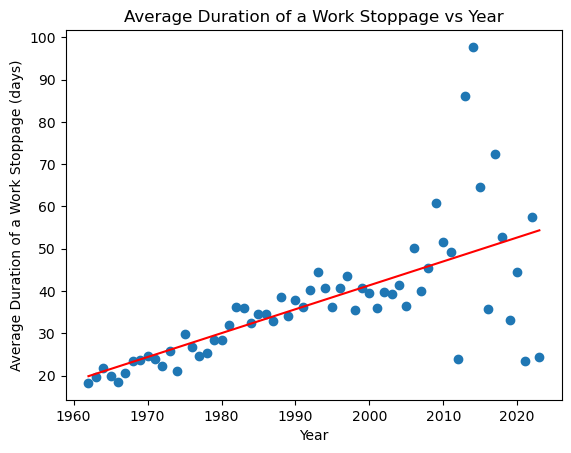

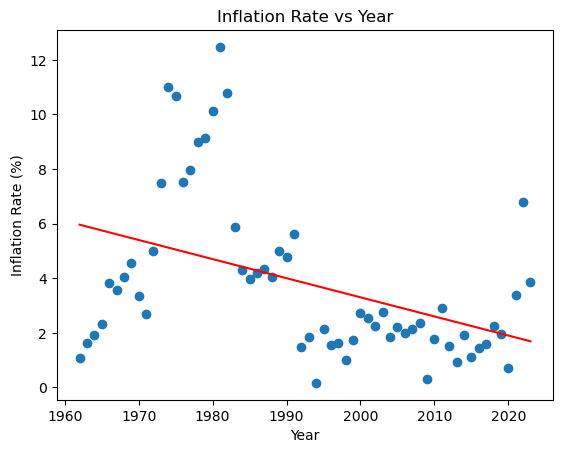

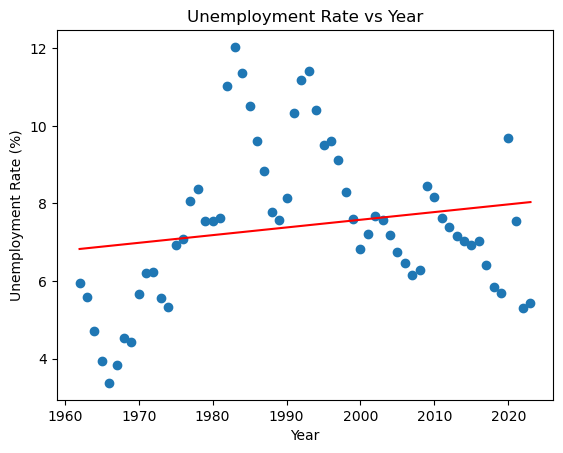

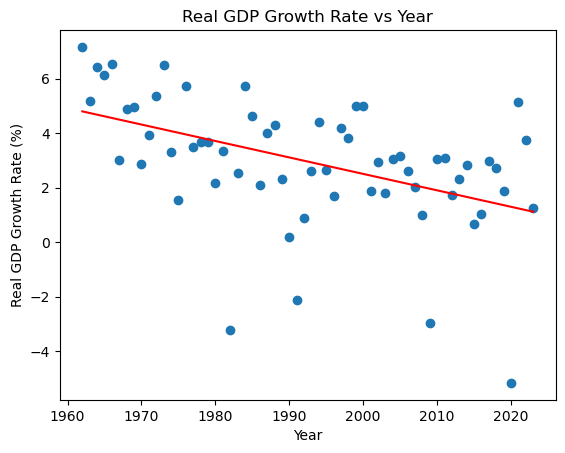

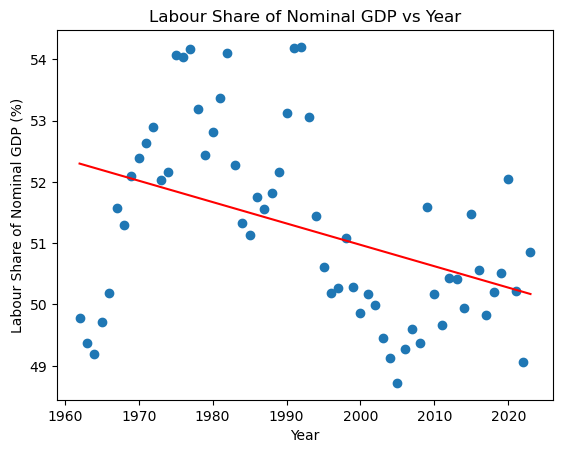

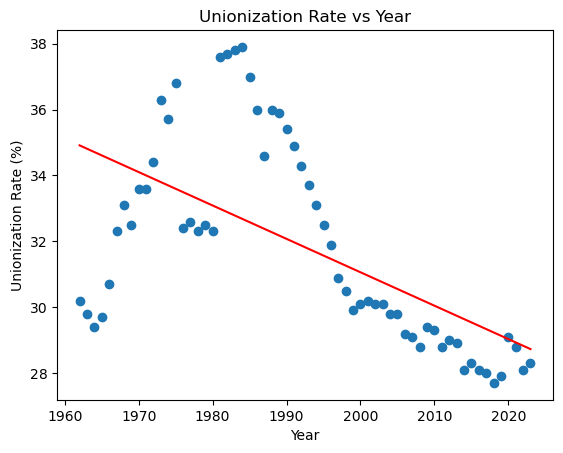

In [105]:
import matplotlib.pyplot as plt
import numpy as np

# Strikes occurrences vs year
plt.scatter(fullDf['year'], fullDf['strikeCounts'])
plt.title('Work Stoppage Counts per 100,000 People vs Year')
plt.xlabel('Year')
plt.ylabel('Work Stoppage Counts')

coeffcients = np.polyfit(fullDf['year'], fullDf['strikeCounts'], 1)
polynomial = np.poly1d(coeffcients)

x_fit = np.linspace(fullDf['year'].min(), fullDf['year'].max(), 100)
y_fit = polynomial(x_fit)

# Plot the line of best fit
plt.plot(x_fit, y_fit, color='red', label='Line of Best Fit')

plt.show()

# Strike days not worked vs year
plt.scatter(fullDf['year'], fullDf['strikesDaysNotWorked'])
plt.title('Days Lost To Work Stoppages per 100,000 People vs Year')
plt.xlabel('Year')
plt.ylabel('Days Lost Due to Work Stoppages')

coeffcients = np.polyfit(fullDf['year'], fullDf['strikesDaysNotWorked'], 1)
polynomial = np.poly1d(coeffcients)

x_fit = np.linspace(fullDf['year'].min(), fullDf['year'].max(), 100)
y_fit = polynomial(x_fit)

# Plot the line of best fit
plt.plot(x_fit, y_fit, color='red', label='Line of Best Fit')

plt.show()

# Average duration of a strike vs year
plt.scatter(fullDf['year'], fullDf['strikeAverageDurations'])
plt.title('Average Duration of a Work Stoppage vs Year')
plt.xlabel('Year')
plt.ylabel('Average Duration of a Work Stoppage (days)')

coeffcients = np.polyfit(fullDf['year'], fullDf['strikeAverageDurations'], 1)
polynomial = np.poly1d(coeffcients)

x_fit = np.linspace(fullDf['year'].min(), fullDf['year'].max(), 100)
y_fit = polynomial(x_fit)

# Plot the line of best fit
plt.plot(x_fit, y_fit, color='red', label='Line of Best Fit')

plt.show()

# Inflation rate vs year
plt.scatter(fullDf['year'], fullDf['inflationRate'])
plt.title('Inflation Rate vs Year')
plt.xlabel('Year')
plt.ylabel('Inflation Rate (%)')

coeffcients = np.polyfit(fullDf['year'], fullDf['inflationRate'], 1)
polynomial = np.poly1d(coeffcients)

x_fit = np.linspace(fullDf['year'].min(), fullDf['year'].max(), 100)
y_fit = polynomial(x_fit)

# Plot the line of best fit
plt.plot(x_fit, y_fit, color='red', label='Line of Best Fit')

plt.show()

# Unemployment rate vs year
plt.scatter(fullDf['year'], fullDf['unemploymentRate'])
plt.title('Unemployment Rate vs Year')
plt.xlabel('Year')
plt.ylabel('Unemployment Rate (%)')

coeffcients = np.polyfit(fullDf['year'], fullDf['unemploymentRate'], 1)
polynomial = np.poly1d(coeffcients)

x_fit = np.linspace(fullDf['year'].min(), fullDf['year'].max(), 100)
y_fit = polynomial(x_fit)

# Plot the line of best fit
plt.plot(x_fit, y_fit, color='red', label='Line of Best Fit')

plt.show()

# GDP growth rate vs year
plt.scatter(fullDf['year'], fullDf['realGdpGrowthRate'])
plt.title('Real GDP Growth Rate vs Year')
plt.xlabel('Year')
plt.ylabel('Real GDP Growth Rate (%)')

coeffcients = np.polyfit(fullDf['year'], fullDf['realGdpGrowthRate'], 1)
polynomial = np.poly1d(coeffcients)

x_fit = np.linspace(fullDf['year'].min(), fullDf['year'].max(), 100)
y_fit = polynomial(x_fit)

# Plot the line of best fit
plt.plot(x_fit, y_fit, color='red', label='Line of Best Fit')

plt.show()

# Labour share of nominal GDP

plt.scatter(fullDf['year'], fullDf['labourShare'])
plt.title('Labour Share of Nominal GDP vs Year')
plt.xlabel('Year')
plt.ylabel('Labour Share of Nominal GDP (%)')

coeffcients = np.polyfit(fullDf['year'], fullDf['labourShare'], 1)
polynomial = np.poly1d(coeffcients)

x_fit = np.linspace(fullDf['year'].min(), fullDf['year'].max(), 100)
y_fit = polynomial(x_fit)

# Plot the line of best fit
plt.plot(x_fit, y_fit, color='red', label='Line of Best Fit')

plt.show()

# Unionization rate
plt.scatter(fullDf['year'], fullDf['unionizationRate'])
plt.title('Unionization Rate vs Year')
plt.xlabel('Year')
plt.ylabel('Unionization Rate (%)')

coeffcients = np.polyfit(fullDf['year'], fullDf['unionizationRate'], 1)
polynomial = np.poly1d(coeffcients)

x_fit = np.linspace(fullDf['year'].min(), fullDf['year'].max(), 100)
y_fit = polynomial(x_fit)

# Plot the line of best fit
plt.plot(x_fit, y_fit, color='red', label='Line of Best Fit')

plt.show()

In [106]:
import statsmodels.formula.api as smf
import statsmodels.stats.diagnostic as dg
import statsmodels.tsa.stattools as tsa

# Define helper functions for models

def getStrikesFormula(variableName):
    return f"{variableName} ~ inflationRate + inflationRate: inflationTargetingPeriod + inflationRateChange + inflationRateChange: inflationTargetingPeriod + unemploymentRate + unemploymentRateChange + labourShare + unionizationRate + realGdpGrowthRate + inflationTargetingPeriod"

# Tests for zero mean, homoskedasticity and autocorrelation. 
# Multi-collinearity is not tested formally and the normality of error terms are not included as they are tested in the model output itself.
def testCLRMAssumptions(strikeModel):
    print('MODEL ASSUMPTION TEST RESULTS\n')
    # Test that residuals have a mean of approximately of zero

    print(f"Zero Conditional Mean Test: {strikeModel.resid.mean()}")

    # Testing homoskedasticity assumption
    heteroskedasticityTest = dg.het_white(strikeModel.resid, strikeModel.model.exog)
    print(f"Homoskedasticity Test: {heteroskedasticityTest}")
    
    # Test autocorrelation
    autocorrelationTest = dg.acorr_breusch_godfrey(strikeModel, nlags=2)
    print(f"Autocorrelation Test: {autocorrelationTest}")
    
# Test stationarity
def testStationarity(strikeModel):
    # Perform the Augmented Dickey-Fuller test
    adfTest = tsa.adfuller(strikeModel.resid)

    # Extract and print the test statistic and p-value
    adfStatistic, pValue = adfTest[0], adfTest[1]

    print("STATIONARITY TEST RESULTS")
    print(f"ADF Statistic: {adfStatistic}")
    print(f"p-value: {pValue}")

In [107]:
# Strike counts
strikeCountsFormula = getStrikesFormula('strikeCounts')
strikeCountsModel = smf.ols(formula=strikeCountsFormula, data=fullDf).fit()
print(strikeCountsModel.summary())

testCLRMAssumptions(strikeCountsModel)
testStationarity(strikeCountsModel)

print('\n\nRevised model to be heteroskedastic and autocorrelation robust:')
strikeCountsModel = smf.ols(formula=strikeCountsFormula, data=fullDf).fit(cov_type='HAC', cov_kwds={'maxlags': 2})
strikeCountsSummary = strikeCountsModel.summary()

print(strikeCountsSummary)


                            OLS Regression Results                            
Dep. Variable:           strikeCounts   R-squared:                       0.919
Model:                            OLS   Adj. R-squared:                  0.903
Method:                 Least Squares   F-statistic:                     57.52
Date:                Sat, 10 Aug 2024   Prob (F-statistic):           3.11e-24
Time:                        21:39:16   Log-Likelihood:                -27.815
No. Observations:                  62   AIC:                             77.63
Df Residuals:                      51   BIC:                             101.0
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                                           coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------

In [108]:
# Days not worked from strikes

strikesDaysNotWorkedFormula = getStrikesFormula('strikesDaysNotWorked')
strikesDaysNotWorkedModel = smf.ols(formula=strikesDaysNotWorkedFormula, data=fullDf).fit()
print(strikesDaysNotWorkedModel.summary())

testCLRMAssumptions(strikesDaysNotWorkedModel)
testStationarity(strikesDaysNotWorkedModel)

print('\n\nRevise Model to be heteroskedastically robust:')
strikesDaysNotWorkedModel = smf.ols(formula=strikesDaysNotWorkedFormula, data=fullDf).fit(cov_type="HC1")
print(strikesDaysNotWorkedModel.summary())

                             OLS Regression Results                             
Dep. Variable:     strikesDaysNotWorked   R-squared:                       0.807
Model:                              OLS   Adj. R-squared:                  0.769
Method:                   Least Squares   F-statistic:                     21.36
Date:                  Sat, 10 Aug 2024   Prob (F-statistic):           6.59e-15
Time:                          21:39:16   Log-Likelihood:                -620.08
No. Observations:                    62   AIC:                             1262.
Df Residuals:                        51   BIC:                             1286.
Df Model:                            10                                         
Covariance Type:              nonrobust                                         
                                                           coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------

In [109]:
# Strike average durations

strikeAverageDurationsFormula = getStrikesFormula('strikeAverageDurations')
strikeAverageDurationsModel = smf.ols(formula=strikeAverageDurationsFormula, data=fullDf).fit()
print(strikeAverageDurationsModel.summary())

testCLRMAssumptions(strikeAverageDurationsModel)
testStationarity(strikeAverageDurationsModel)

# No violation of homoskedasticity or autocorrelation
print('No updated covariances needed as there is no violation of serial correlation and homoskedasticity assumption.')

                              OLS Regression Results                              
Dep. Variable:     strikeAverageDurations   R-squared:                       0.462
Model:                                OLS   Adj. R-squared:                  0.356
Method:                     Least Squares   F-statistic:                     4.379
Date:                    Sat, 10 Aug 2024   Prob (F-statistic):           0.000191
Time:                            21:39:16   Log-Likelihood:                -237.83
No. Observations:                      62   AIC:                             497.7
Df Residuals:                          51   BIC:                             521.1
Df Model:                              10                                         
Covariance Type:                nonrobust                                         
                                                           coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------